# 付録A10: ホモフィリー（同類選好）

## 学習目標

この付録では、ネットワーク科学における重要な概念「ホモフィリー」について学びます。

- ホモフィリーの定義と種類を理解する
- 同類性係数（assortativity coefficient）でホモフィリーを測定する
- ホモフィリーに基づくネットワーク形成をシミュレーションする
- ホモフィリーが情報伝播と社会的分断に与える影響を分析する

## セットアップ

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import defaultdict
import japanize_matplotlib

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['IPAexGothic'] + plt.rcParams['font.sans-serif']
plt.rcParams['figure.figsize'] = (10, 6)

# 再現性のための乱数シード
np.random.seed(42)
random.seed(42)

## A10.1 ホモフィリーとは

### 概念の定義

**ホモフィリー（Homophily）** とは、「似た者同士がつながりやすい」という社会ネットワークの普遍的な傾向です。

- **語源**: ギリシャ語の "homos"（同じ）と "philia"（愛・友情）
- **格言**: "Birds of a feather flock together"（類は友を呼ぶ）

### ホモフィリーの種類

McPherson, Smith-Lovin & Cook (2001) による分類：

1. **ステータス・ホモフィリー（Status Homophily）**
   - 人口統計的属性に基づく類似性
   - 例：年齢、性別、民族、学歴、職業

2. **バリュー・ホモフィリー（Value Homophily）**
   - 内面的な価値観・態度に基づく類似性
   - 例：政治的立場、宗教観、趣味・嗜好

### 形成メカニズム

- **選択（Selection）**: 似た人を選んでつながる
- **社会的影響（Social Influence）**: つながった後に似てくる
- **機会構造（Opportunity Structure）**: 同じ場所にいる人とつながりやすい

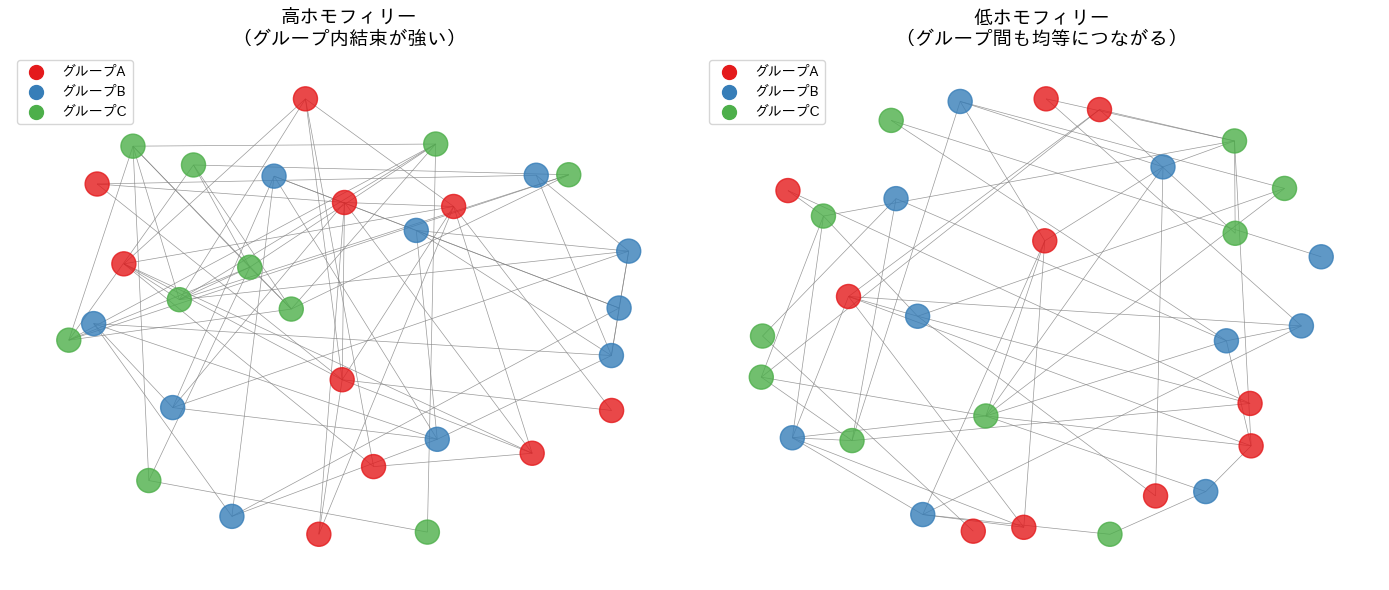

高ホモフィリーネットワーク:
  ノード数: 30, エッジ数: 74

低ホモフィリーネットワーク:
  ノード数: 30, エッジ数: 57


In [2]:
# ホモフィリーの視覚的説明
def create_homophilic_network(n=30, num_groups=3, p_in=0.4, p_out=0.05):
    """
    ホモフィリーを持つネットワークを生成
    
    Parameters:
    -----------
    n : int
        ノード数
    num_groups : int
        グループ数
    p_in : float
        同じグループ内での接続確率
    p_out : float
        異なるグループ間での接続確率
    """
    G = nx.Graph()
    
    # ノードをグループに割り当て
    for i in range(n):
        group = i % num_groups
        G.add_node(i, group=group)
    
    # エッジを確率的に追加
    for i in range(n):
        for j in range(i + 1, n):
            if G.nodes[i]['group'] == G.nodes[j]['group']:
                if random.random() < p_in:
                    G.add_edge(i, j)
            else:
                if random.random() < p_out:
                    G.add_edge(i, j)
    
    return G

# 高ホモフィリーと低ホモフィリーのネットワークを比較
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 高ホモフィリー
G_high = create_homophilic_network(n=30, num_groups=3, p_in=0.5, p_out=0.02)
colors_high = ['#e41a1c', '#377eb8', '#4daf4a']
node_colors_high = [colors_high[G_high.nodes[n]['group']] for n in G_high.nodes()]

pos_high = nx.spring_layout(G_high, seed=42, k=2)
nx.draw(G_high, pos_high, ax=axes[0], node_color=node_colors_high,
        node_size=300, edge_color='gray', alpha=0.8, width=0.5)
axes[0].set_title('高ホモフィリー\n（グループ内結束が強い）', fontsize=14)

# 低ホモフィリー（ほぼランダム）
G_low = create_homophilic_network(n=30, num_groups=3, p_in=0.15, p_out=0.15)
node_colors_low = [colors_high[G_low.nodes[n]['group']] for n in G_low.nodes()]

pos_low = nx.spring_layout(G_low, seed=42, k=2)
nx.draw(G_low, pos_low, ax=axes[1], node_color=node_colors_low,
        node_size=300, edge_color='gray', alpha=0.8, width=0.5)
axes[1].set_title('低ホモフィリー\n（グループ間も均等につながる）', fontsize=14)

# 凡例
for ax in axes:
    for i, (color, label) in enumerate(zip(colors_high, ['グループA', 'グループB', 'グループC'])):
        ax.scatter([], [], c=color, s=100, label=label)
    ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

print("高ホモフィリーネットワーク:")
print(f"  ノード数: {G_high.number_of_nodes()}, エッジ数: {G_high.number_of_edges()}")
print(f"\n低ホモフィリーネットワーク:")
print(f"  ノード数: {G_low.number_of_nodes()}, エッジ数: {G_low.number_of_edges()}")

## A10.2 ホモフィリーの測定

### 同類性係数（Assortativity Coefficient）

Newman (2003) が提案した同類性係数は、ネットワーク内でのホモフィリーの程度を測定します。

#### 属性に基づく同類性係数

カテゴリカル属性の場合：

$$r = \frac{\sum_i e_{ii} - \sum_i a_i b_i}{1 - \sum_i a_i b_i}$$

- $e_{ij}$: タイプiとタイプjを結ぶエッジの割合
- $a_i = \sum_j e_{ij}$, $b_j = \sum_i e_{ij}$
- $r = 1$: 完全な同類性（同じタイプのみが接続）
- $r = 0$: ランダム混合
- $r < 0$: 異類性（異なるタイプが接続しやすい）

#### 次数に基づく同類性係数

高次数ノードが高次数ノードとつながる傾向を測定：
- $r > 0$: 同類的（ハブ同士がつながる）
- $r < 0$: 異類的（ハブは低次数ノードとつながる）

/tmp/ipykernel_4624/2105793266.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


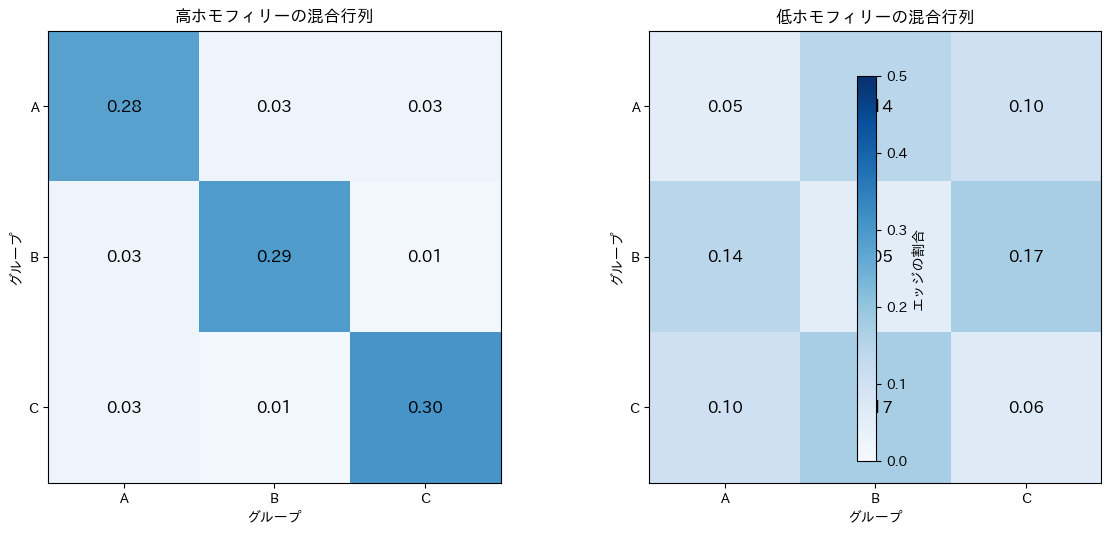

同類性係数（Assortativity Coefficient）:
  高ホモフィリーネットワーク: r = 0.899
  低ホモフィリーネットワーク: r = -0.082

解釈:
  r > 0: 同じグループ同士がつながりやすい（ホモフィリー）
  r ≈ 0: ランダムな混合
  r < 0: 異なるグループ同士がつながりやすい（ヘテロフィリー）


In [3]:
def calculate_mixing_matrix(G, attribute):
    """
    混合行列（Mixing Matrix）を計算
    エッジがどの属性間で張られているかを示す
    """
    # 属性値を取得
    attr_values = set(nx.get_node_attributes(G, attribute).values())
    attr_list = sorted(attr_values)
    n_types = len(attr_list)
    
    # 混合行列を初期化
    mixing = np.zeros((n_types, n_types))
    
    for u, v in G.edges():
        i = attr_list.index(G.nodes[u][attribute])
        j = attr_list.index(G.nodes[v][attribute])
        mixing[i, j] += 1
        if i != j:
            mixing[j, i] += 1  # 無向グラフの場合
    
    # 正規化
    total = mixing.sum()
    if total > 0:
        mixing = mixing / total
    
    return mixing, attr_list

# 高ホモフィリーネットワークの混合行列
mixing_high, groups = calculate_mixing_matrix(G_high, 'group')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 高ホモフィリーの混合行列
im1 = axes[0].imshow(mixing_high, cmap='Blues', vmin=0, vmax=0.5)
axes[0].set_xticks(range(3))
axes[0].set_yticks(range(3))
axes[0].set_xticklabels(['A', 'B', 'C'])
axes[0].set_yticklabels(['A', 'B', 'C'])
axes[0].set_title('高ホモフィリーの混合行列', fontsize=12)
axes[0].set_xlabel('グループ')
axes[0].set_ylabel('グループ')

# 値を表示
for i in range(3):
    for j in range(3):
        axes[0].text(j, i, f'{mixing_high[i, j]:.2f}',
                    ha='center', va='center', fontsize=12)

# 低ホモフィリーの混合行列
mixing_low, _ = calculate_mixing_matrix(G_low, 'group')

im2 = axes[1].imshow(mixing_low, cmap='Blues', vmin=0, vmax=0.5)
axes[1].set_xticks(range(3))
axes[1].set_yticks(range(3))
axes[1].set_xticklabels(['A', 'B', 'C'])
axes[1].set_yticklabels(['A', 'B', 'C'])
axes[1].set_title('低ホモフィリーの混合行列', fontsize=12)
axes[1].set_xlabel('グループ')
axes[1].set_ylabel('グループ')

for i in range(3):
    for j in range(3):
        axes[1].text(j, i, f'{mixing_low[i, j]:.2f}',
                    ha='center', va='center', fontsize=12)

plt.colorbar(im1, ax=axes, label='エッジの割合')
plt.tight_layout()
plt.show()

# NetworkXの同類性係数
r_high = nx.attribute_assortativity_coefficient(G_high, 'group')
r_low = nx.attribute_assortativity_coefficient(G_low, 'group')

print(f"同類性係数（Assortativity Coefficient）:")
print(f"  高ホモフィリーネットワーク: r = {r_high:.3f}")
print(f"  低ホモフィリーネットワーク: r = {r_low:.3f}")
print(f"\n解釈:")
print(f"  r > 0: 同じグループ同士がつながりやすい（ホモフィリー）")
print(f"  r ≈ 0: ランダムな混合")
print(f"  r < 0: 異なるグループ同士がつながりやすい（ヘテロフィリー）")

In [4]:
def calculate_ei_index(G, attribute):
    """
    E-I Index（External-Internal Index）を計算
    Krackhardt & Stern (1988)
    
    EI = (E - I) / (E + I)
    E: グループ間エッジ数
    I: グループ内エッジ数
    
    範囲: [-1, 1]
    -1: 完全なホモフィリー（グループ内のみ）
     0: バランス
    +1: 完全なヘテロフィリー（グループ間のみ）
    """
    external = 0
    internal = 0
    
    for u, v in G.edges():
        if G.nodes[u][attribute] == G.nodes[v][attribute]:
            internal += 1
        else:
            external += 1
    
    total = external + internal
    if total == 0:
        return 0
    
    return (external - internal) / total

# E-I Indexの計算
ei_high = calculate_ei_index(G_high, 'group')
ei_low = calculate_ei_index(G_low, 'group')

print("E-I Index（External-Internal Index）:")
print(f"  高ホモフィリーネットワーク: EI = {ei_high:.3f}")
print(f"  低ホモフィリーネットワーク: EI = {ei_low:.3f}")
print(f"\n解釈:")
print(f"  EI = -1: 完全なホモフィリー（グループ内接続のみ）")
print(f"  EI =  0: グループ内外のバランス")
print(f"  EI = +1: 完全なヘテロフィリー（グループ間接続のみ）")

E-I Index（External-Internal Index）:
  高ホモフィリーネットワーク: EI = -0.865
  低ホモフィリーネットワーク: EI = 0.439

解釈:
  EI = -1: 完全なホモフィリー（グループ内接続のみ）
  EI =  0: グループ内外のバランス
  EI = +1: 完全なヘテロフィリー（グループ間接続のみ）


## A10.3 次数に基づく同類性

ノードの次数（接続数）に関する同類性も重要な指標です。

- **同類的（Assortative）**: 高次数ノードが高次数ノードとつながる
  - 例：社会ネットワーク（人気者同士がつながる）
  
- **異類的（Disassortative）**: 高次数ノードが低次数ノードとつながる
  - 例：生物ネットワーク、技術ネットワーク（ハブがスポークに接続）

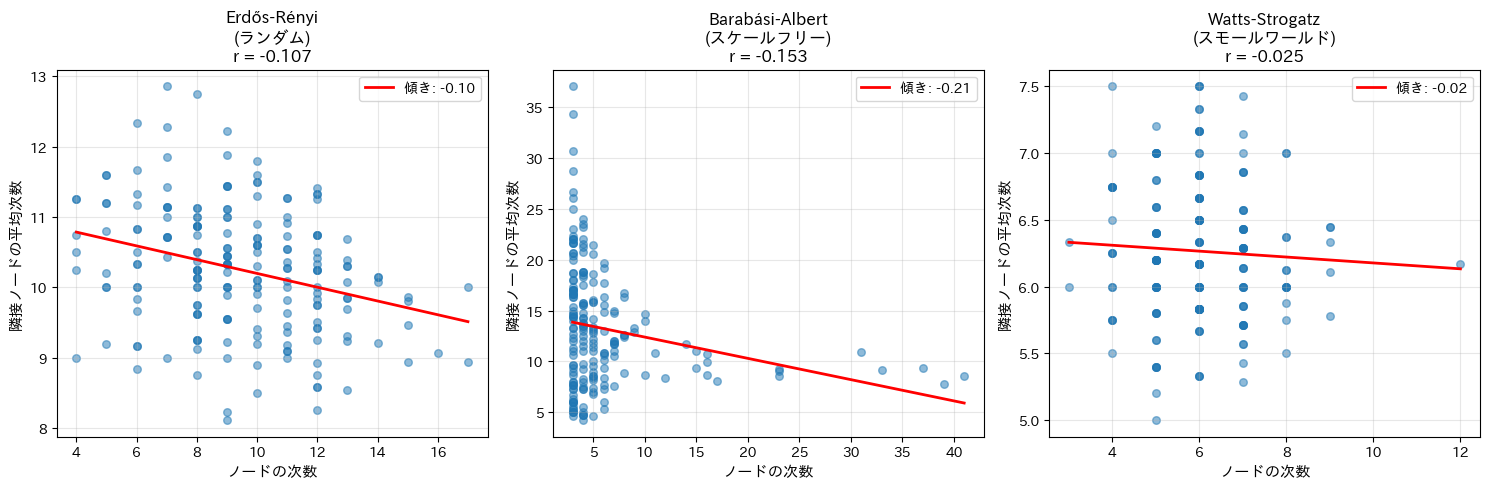

次数同類性係数の比較:
  Erdős-Rényi (ランダム): r = -0.107 (異類的)
  Barabási-Albert (スケールフリー): r = -0.153 (異類的)
  Watts-Strogatz (スモールワールド): r = -0.025 (中立)


In [5]:
# 様々なネットワークの次数同類性を比較
networks = {
    'Erdős-Rényi\n(ランダム)': nx.erdos_renyi_graph(200, 0.05, seed=42),
    'Barabási-Albert\n(スケールフリー)': nx.barabasi_albert_graph(200, 3, seed=42),
    'Watts-Strogatz\n(スモールワールド)': nx.watts_strogatz_graph(200, 6, 0.3, seed=42),
}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (name, G) in zip(axes, networks.items()):
    # 隣接ノードの平均次数を計算
    degree_dict = dict(G.degree())
    avg_neighbor_degree = nx.average_neighbor_degree(G)
    
    degrees = list(degree_dict.values())
    neighbor_degrees = [avg_neighbor_degree[n] for n in G.nodes()]
    
    ax.scatter(degrees, neighbor_degrees, alpha=0.5, s=30)
    
    # 回帰直線
    z = np.polyfit(degrees, neighbor_degrees, 1)
    p = np.poly1d(z)
    x_line = np.linspace(min(degrees), max(degrees), 100)
    ax.plot(x_line, p(x_line), 'r-', linewidth=2, label=f'傾き: {z[0]:.2f}')
    
    # 次数同類性係数
    r = nx.degree_assortativity_coefficient(G)
    
    ax.set_xlabel('ノードの次数', fontsize=11)
    ax.set_ylabel('隣接ノードの平均次数', fontsize=11)
    ax.set_title(f'{name}\nr = {r:.3f}', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("次数同類性係数の比較:")
for name, G in networks.items():
    r = nx.degree_assortativity_coefficient(G)
    interpretation = "同類的" if r > 0.05 else "異類的" if r < -0.05 else "中立"
    print(f"  {name.replace(chr(10), ' ')}: r = {r:.3f} ({interpretation})")

## A10.4 ホモフィリーに基づくネットワーク形成

### シミュレーションモデル

ホモフィリーを考慮したネットワーク形成モデルをシミュレーションします。

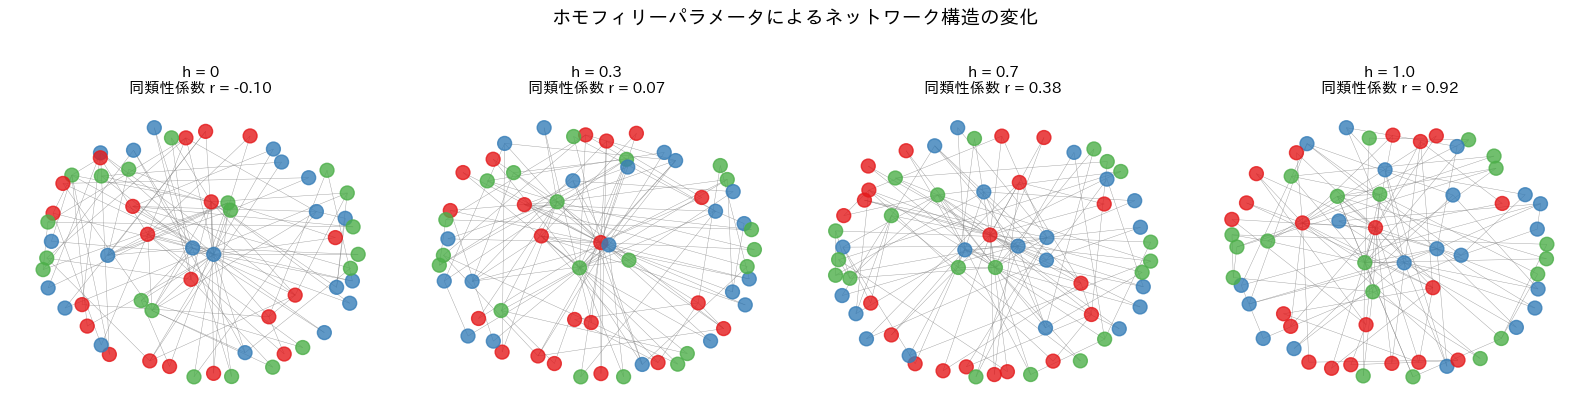

In [6]:
def homophilic_network_formation(n, num_types, h, m=3, seed=None):
    """
    ホモフィリーを考慮したネットワーク形成モデル
    優先的選択 + ホモフィリー
    
    Parameters:
    -----------
    n : int
        最終ノード数
    num_types : int
        属性タイプ数
    h : float
        ホモフィリーパラメータ (0-1)
        h=0: ホモフィリーなし（純粋な優先的選択）
        h=1: 完全なホモフィリー（同じタイプのみ接続）
    m : int
        各新規ノードが追加するエッジ数
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    
    # 初期グラフ（完全グラフ）
    G = nx.complete_graph(m + 1)
    for node in G.nodes():
        G.nodes[node]['type'] = node % num_types
    
    # ノードを追加
    for new_node in range(m + 1, n):
        new_type = new_node % num_types
        G.add_node(new_node, type=new_type)
        
        # 接続先を選択
        targets = set()
        existing_nodes = list(G.nodes())[:-1]  # 新規ノード以外
        
        while len(targets) < m and len(targets) < len(existing_nodes):
            # 優先的選択 + ホモフィリーの重み
            weights = []
            for node in existing_nodes:
                if node in targets:
                    weights.append(0)
                else:
                    degree = G.degree(node)
                    same_type = 1 if G.nodes[node]['type'] == new_type else 0
                    # ホモフィリーの影響を加味
                    weight = degree * (h * same_type + (1 - h))
                    weights.append(max(weight, 0.001))
            
            # 正規化
            total = sum(weights)
            probs = [w / total for w in weights]
            
            # 選択
            chosen = np.random.choice(existing_nodes, p=probs)
            targets.add(chosen)
        
        # エッジを追加
        for target in targets:
            G.add_edge(new_node, target)
    
    return G

# 異なるホモフィリーレベルでネットワークを生成
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

h_values = [0, 0.3, 0.7, 1.0]
colors = ['#e41a1c', '#377eb8', '#4daf4a']

for ax, h in zip(axes, h_values):
    G = homophilic_network_formation(60, 3, h, m=2, seed=42)
    
    node_colors = [colors[G.nodes[n]['type']] for n in G.nodes()]
    pos = nx.spring_layout(G, seed=42, k=1.5)
    
    nx.draw(G, pos, ax=ax, node_color=node_colors,
            node_size=100, edge_color='gray', alpha=0.8, width=0.3)
    
    r = nx.attribute_assortativity_coefficient(G, 'type')
    ax.set_title(f'h = {h}\n同類性係数 r = {r:.2f}', fontsize=11)

plt.suptitle('ホモフィリーパラメータによるネットワーク構造の変化', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

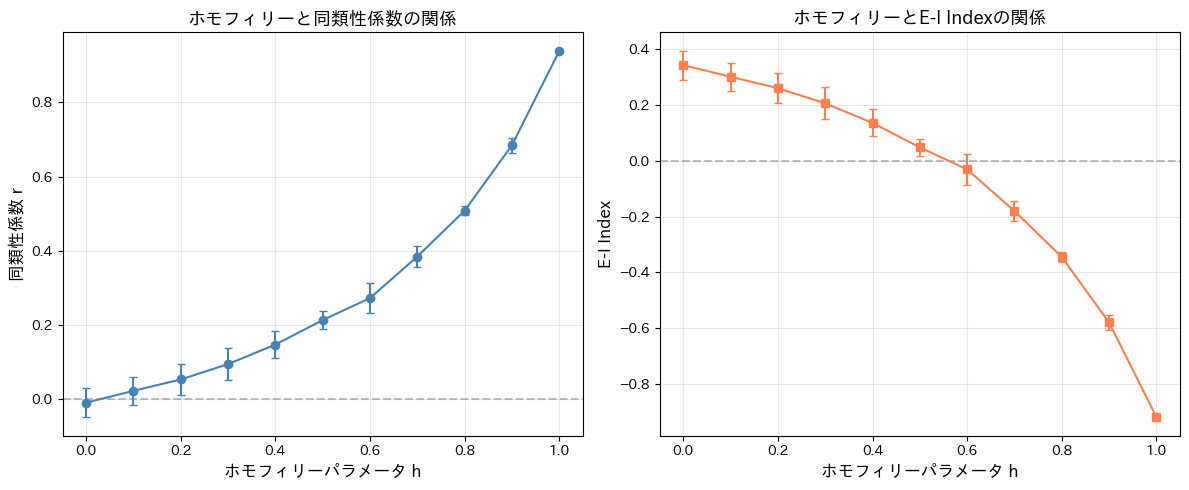

In [7]:
# ホモフィリーレベルと同類性係数の関係
h_range = np.linspace(0, 1, 11)
assortativity_values = []
ei_values = []

n_trials = 10

for h in h_range:
    r_trials = []
    ei_trials = []
    
    for trial in range(n_trials):
        G = homophilic_network_formation(100, 3, h, m=3, seed=trial)
        r_trials.append(nx.attribute_assortativity_coefficient(G, 'type'))
        ei_trials.append(calculate_ei_index(G, 'type'))
    
    assortativity_values.append((np.mean(r_trials), np.std(r_trials)))
    ei_values.append((np.mean(ei_trials), np.std(ei_trials)))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 同類性係数
means = [v[0] for v in assortativity_values]
stds = [v[1] for v in assortativity_values]
axes[0].errorbar(h_range, means, yerr=stds, fmt='o-', capsize=3, color='steelblue')
axes[0].set_xlabel('ホモフィリーパラメータ h', fontsize=12)
axes[0].set_ylabel('同類性係数 r', fontsize=12)
axes[0].set_title('ホモフィリーと同類性係数の関係', fontsize=13)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# E-I Index
means_ei = [v[0] for v in ei_values]
stds_ei = [v[1] for v in ei_values]
axes[1].errorbar(h_range, means_ei, yerr=stds_ei, fmt='s-', capsize=3, color='coral')
axes[1].set_xlabel('ホモフィリーパラメータ h', fontsize=12)
axes[1].set_ylabel('E-I Index', fontsize=12)
axes[1].set_title('ホモフィリーとE-I Indexの関係', fontsize=13)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## A10.5 ホモフィリーと情報伝播

ホモフィリーは情報の拡散パターンに大きな影響を与えます。

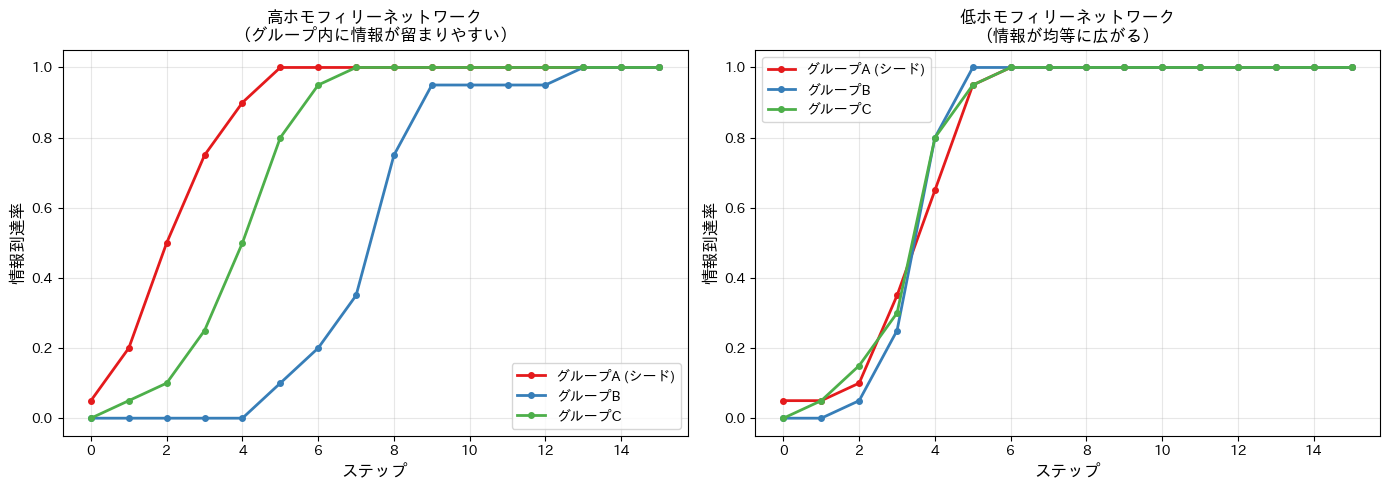

最終的な情報到達率:

高ホモフィリーネットワーク:
  グループA (シード): 100.0%
  グループB: 100.0%
  グループC: 100.0%

低ホモフィリーネットワーク:
  グループA (シード): 100.0%
  グループB: 100.0%
  グループC: 100.0%


In [8]:
def simulate_information_spread(G, attribute, seed_node, steps=20):
    """
    情報拡散シミュレーション
    各ステップで、情報を持つノードの隣接ノードに確率0.3で情報が伝わる
    """
    informed = {seed_node}
    history = [informed.copy()]
    
    # グループごとの情報到達を追跡
    seed_type = G.nodes[seed_node][attribute]
    
    for _ in range(steps):
        new_informed = set()
        for node in informed:
            for neighbor in G.neighbors(node):
                if neighbor not in informed and random.random() < 0.3:
                    new_informed.add(neighbor)
        informed.update(new_informed)
        history.append(informed.copy())
    
    return history

# 高ホモフィリー vs 低ホモフィリーでの情報拡散比較
np.random.seed(42)
random.seed(42)

G_high_homo = create_homophilic_network(n=60, num_groups=3, p_in=0.4, p_out=0.02)
G_low_homo = create_homophilic_network(n=60, num_groups=3, p_in=0.15, p_out=0.15)

# 同じシードノードから開始
seed = 0
steps = 15

history_high = simulate_information_spread(G_high_homo, 'group', seed, steps)
history_low = simulate_information_spread(G_low_homo, 'group', seed, steps)

# グループごとの情報到達率を計算
def get_group_reach(G, history, attribute):
    """各ステップでのグループごとの情報到達率"""
    groups = set(nx.get_node_attributes(G, attribute).values())
    group_counts = {g: sum(1 for n in G.nodes() if G.nodes[n][attribute] == g) for g in groups}
    
    reach_by_group = {g: [] for g in groups}
    
    for informed in history:
        for g in groups:
            informed_in_group = sum(1 for n in informed if G.nodes[n][attribute] == g)
            reach_by_group[g].append(informed_in_group / group_counts[g])
    
    return reach_by_group

reach_high = get_group_reach(G_high_homo, history_high, 'group')
reach_low = get_group_reach(G_low_homo, history_low, 'group')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = ['#e41a1c', '#377eb8', '#4daf4a']
group_names = ['グループA (シード)', 'グループB', 'グループC']

# 高ホモフィリー
for i, (g, reach) in enumerate(reach_high.items()):
    axes[0].plot(range(steps + 1), reach, 'o-', color=colors[g], 
                label=group_names[g], linewidth=2, markersize=4)
axes[0].set_xlabel('ステップ', fontsize=12)
axes[0].set_ylabel('情報到達率', fontsize=12)
axes[0].set_title('高ホモフィリーネットワーク\n（グループ内に情報が留まりやすい）', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-0.05, 1.05)

# 低ホモフィリー
for i, (g, reach) in enumerate(reach_low.items()):
    axes[1].plot(range(steps + 1), reach, 'o-', color=colors[g],
                label=group_names[g], linewidth=2, markersize=4)
axes[1].set_xlabel('ステップ', fontsize=12)
axes[1].set_ylabel('情報到達率', fontsize=12)
axes[1].set_title('低ホモフィリーネットワーク\n（情報が均等に広がる）', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

print("最終的な情報到達率:")
print(f"\n高ホモフィリーネットワーク:")
for g, reach in reach_high.items():
    print(f"  {group_names[g]}: {reach[-1]*100:.1f}%")
print(f"\n低ホモフィリーネットワーク:")
for g, reach in reach_low.items():
    print(f"  {group_names[g]}: {reach[-1]*100:.1f}%")

## A10.6 ホモフィリーと社会的分断

強いホモフィリーは社会的分断（セグリゲーション）につながる可能性があります。

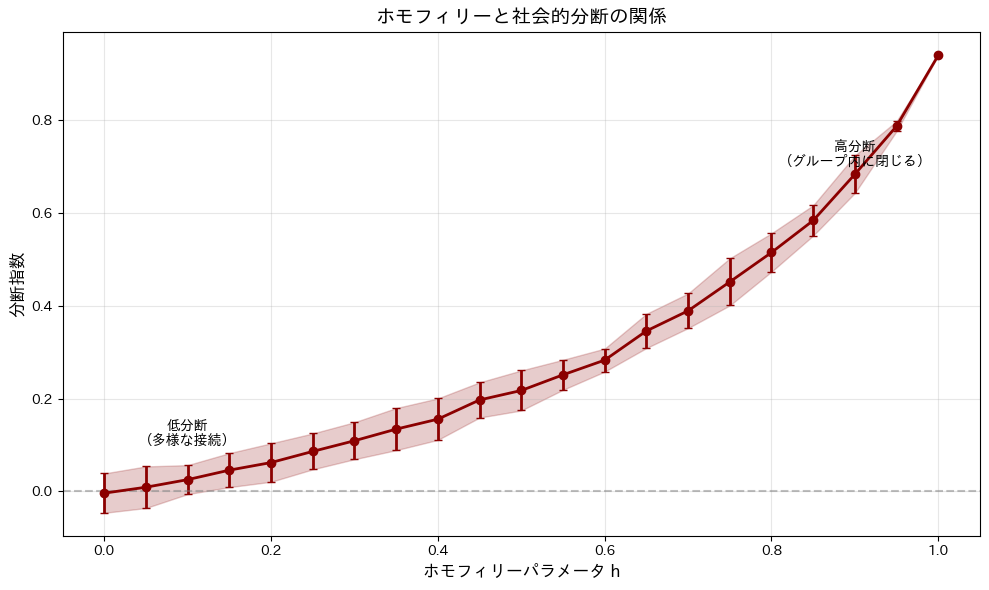

In [9]:
def calculate_segregation_index(G, attribute):
    """
    分断指数（Segregation Index）を計算
    Freeman (1978) の分離指数に基づく
    """
    # グループごとの統計
    groups = set(nx.get_node_attributes(G, attribute).values())
    
    total_within = 0
    total_between = 0
    
    for u, v in G.edges():
        if G.nodes[u][attribute] == G.nodes[v][attribute]:
            total_within += 1
        else:
            total_between += 1
    
    # 期待値を計算
    n = G.number_of_nodes()
    m = G.number_of_edges()
    
    group_sizes = {}
    for g in groups:
        group_sizes[g] = sum(1 for node in G.nodes() if G.nodes[node][attribute] == g)
    
    # 期待されるグループ内エッジの割合
    expected_within = sum((size / n) ** 2 for size in group_sizes.values())
    
    if m == 0:
        return 0
    
    observed_within = total_within / m
    
    # 分断指数
    if expected_within >= 1:
        return 0
    
    return (observed_within - expected_within) / (1 - expected_within)

# 様々なホモフィリーレベルでの分断指数
h_range = np.linspace(0, 1, 21)
segregation_indices = []

for h in h_range:
    indices = []
    for trial in range(10):
        G = homophilic_network_formation(100, 3, h, m=3, seed=trial + 100)
        indices.append(calculate_segregation_index(G, 'type'))
    segregation_indices.append((np.mean(indices), np.std(indices)))

fig, ax = plt.subplots(figsize=(10, 6))

means = [v[0] for v in segregation_indices]
stds = [v[1] for v in segregation_indices]

ax.errorbar(h_range, means, yerr=stds, fmt='o-', capsize=3, 
            color='darkred', linewidth=2, markersize=6)
ax.fill_between(h_range, 
                [m - s for m, s in zip(means, stds)],
                [m + s for m, s in zip(means, stds)],
                alpha=0.2, color='darkred')

ax.set_xlabel('ホモフィリーパラメータ h', fontsize=12)
ax.set_ylabel('分断指数', fontsize=12)
ax.set_title('ホモフィリーと社会的分断の関係', fontsize=14)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# 注釈
ax.annotate('低分断\n（多様な接続）', xy=(0.1, 0.1), fontsize=10, ha='center')
ax.annotate('高分断\n（グループ内に閉じる）', xy=(0.9, 0.7), fontsize=10, ha='center')

plt.tight_layout()
plt.show()

## A10.7 実世界でのホモフィリー分析

実際のネットワークデータでホモフィリーを分析してみましょう。

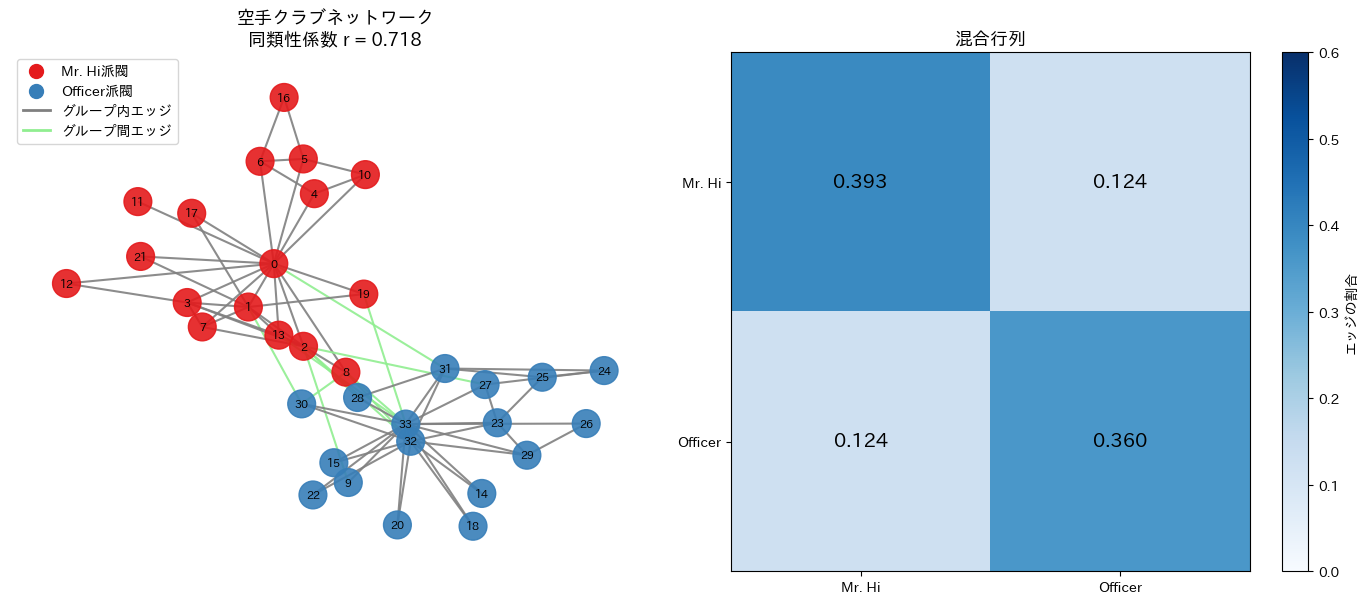

空手クラブネットワークのホモフィリー分析:
  同類性係数 r = 0.718
  E-I Index = -0.718

解釈: 派閥内での接続が派閥間より強い（ホモフィリーあり）


In [10]:
# Karateクラブネットワーク（派閥による分裂）
G_karate = nx.karate_club_graph()

# 派閥情報を取得
club_labels = nx.get_node_attributes(G_karate, 'club')

# 数値に変換
for node in G_karate.nodes():
    G_karate.nodes[node]['faction'] = 0 if club_labels[node] == 'Mr. Hi' else 1

# 同類性係数を計算
r_karate = nx.attribute_assortativity_coefficient(G_karate, 'faction')
ei_karate = calculate_ei_index(G_karate, 'faction')

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ネットワーク図
pos = nx.spring_layout(G_karate, seed=42)
colors = ['#e41a1c' if G_karate.nodes[n]['faction'] == 0 else '#377eb8' 
          for n in G_karate.nodes()]

# エッジの色（グループ内/グループ間）
edge_colors = []
for u, v in G_karate.edges():
    if G_karate.nodes[u]['faction'] == G_karate.nodes[v]['faction']:
        edge_colors.append('gray')
    else:
        edge_colors.append('lightgreen')

nx.draw(G_karate, pos, ax=axes[0], node_color=colors,
        edge_color=edge_colors, node_size=400, width=1.5, alpha=0.9)

# ノードラベル
nx.draw_networkx_labels(G_karate, pos, ax=axes[0], font_size=8)

axes[0].set_title(f'空手クラブネットワーク\n同類性係数 r = {r_karate:.3f}', fontsize=13)

# 凡例
axes[0].scatter([], [], c='#e41a1c', s=100, label="Mr. Hi派閥")
axes[0].scatter([], [], c='#377eb8', s=100, label="Officer派閥")
axes[0].plot([], [], c='gray', linewidth=2, label="グループ内エッジ")
axes[0].plot([], [], c='lightgreen', linewidth=2, label="グループ間エッジ")
axes[0].legend(loc='upper left')

# 混合行列
mixing, _ = calculate_mixing_matrix(G_karate, 'faction')
im = axes[1].imshow(mixing, cmap='Blues', vmin=0, vmax=0.6)
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(['Mr. Hi', 'Officer'])
axes[1].set_yticklabels(['Mr. Hi', 'Officer'])
axes[1].set_title('混合行列', fontsize=13)

for i in range(2):
    for j in range(2):
        axes[1].text(j, i, f'{mixing[i, j]:.3f}',
                    ha='center', va='center', fontsize=14, fontweight='bold')

plt.colorbar(im, ax=axes[1], label='エッジの割合')
plt.tight_layout()
plt.show()

print(f"空手クラブネットワークのホモフィリー分析:")
print(f"  同類性係数 r = {r_karate:.3f}")
print(f"  E-I Index = {ei_karate:.3f}")
print(f"\n解釈: 派閥内での接続が派閥間より強い（ホモフィリーあり）")

## A10.8 まとめ

### ホモフィリーの主要概念

| 概念 | 説明 |
|------|------|
| ホモフィリー | 類似した属性を持つノード同士がつながりやすい傾向 |
| ステータス・ホモフィリー | 年齢・性別・学歴など人口統計的属性に基づく類似性 |
| バリュー・ホモフィリー | 価値観・態度・意見に基づく類似性 |
| 同類性係数 | ホモフィリーの程度を測定する指標（-1〜1） |
| E-I Index | グループ内外の接続バランスを測定する指標 |

### ホモフィリーの影響

1. **情報伝播への影響**
   - 高ホモフィリー → 情報がグループ内に留まりやすい
   - 低ホモフィリー → 情報が広く拡散

2. **社会的分断**
   - 強いホモフィリーはエコーチェンバーや社会的分断を生む
   - 弱い紐帯（グループ間接続）が多様性を維持

3. **ネットワーク構造**
   - コミュニティ構造の形成
   - 次数同類性にも影響

---

## 練習問題

### 問題1: 同類性の測定

以下の条件でネットワークを生成し、同類性係数とE-I Indexを計算してください：
- ノード数: 100
- 3つの属性グループ（均等に分布）
- グループ内接続確率: 0.3
- グループ間接続確率: 0.05

In [11]:
# ここにコードを書いてください


<details>
<summary>解答例を見る</summary>

```python
# ネットワークを生成
G = create_homophilic_network(n=100, num_groups=3, p_in=0.3, p_out=0.05)

# 同類性係数を計算
r = nx.attribute_assortativity_coefficient(G, 'group')
print(f"同類性係数: r = {r:.3f}")

# E-I Indexを計算
ei = calculate_ei_index(G, 'group')
print(f"E-I Index: {ei:.3f}")

# 混合行列を表示
mixing, groups = calculate_mixing_matrix(G, 'group')
print(f"\n混合行列:")
print(mixing.round(3))

# 可視化
pos = nx.spring_layout(G, seed=42)
colors = ['#e41a1c', '#377eb8', '#4daf4a']
node_colors = [colors[G.nodes[n]['group']] for n in G.nodes()]

plt.figure(figsize=(10, 8))
nx.draw(G, pos, node_color=node_colors, node_size=100,
        edge_color='gray', alpha=0.7, width=0.5)
plt.title(f'ホモフィリーネットワーク\nr = {r:.3f}, E-I = {ei:.3f}')
plt.show()
```
</details>

### 問題2: ホモフィリーと連結性

ホモフィリーレベル（h）を0から1まで変化させながら、以下を測定してください：
1. ネットワークが連結かどうか
2. 連結でない場合、最大連結成分のサイズ
3. 平均クラスタリング係数

結果をグラフで可視化してください。

In [12]:
# ここにコードを書いてください


<details>
<summary>解答例を見る</summary>

```python
h_range = np.linspace(0, 1, 21)
connectivity = []
largest_cc = []
clustering = []

n_trials = 10

for h in h_range:
    conn_trials = []
    cc_trials = []
    clust_trials = []
    
    for trial in range(n_trials):
        G = homophilic_network_formation(100, 3, h, m=2, seed=trial)
        
        conn_trials.append(nx.is_connected(G))
        cc_trials.append(len(max(nx.connected_components(G), key=len)) / G.number_of_nodes())
        clust_trials.append(nx.average_clustering(G))
    
    connectivity.append(np.mean(conn_trials))
    largest_cc.append(np.mean(cc_trials))
    clustering.append(np.mean(clust_trials))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(h_range, connectivity, 'o-', color='steelblue')
axes[0].set_xlabel('ホモフィリー h')
axes[0].set_ylabel('連結確率')
axes[0].set_title('ホモフィリーと連結性')
axes[0].grid(True, alpha=0.3)

axes[1].plot(h_range, largest_cc, 's-', color='coral')
axes[1].set_xlabel('ホモフィリー h')
axes[1].set_ylabel('最大連結成分の割合')
axes[1].set_title('最大連結成分サイズ')
axes[1].grid(True, alpha=0.3)

axes[2].plot(h_range, clustering, '^-', color='green')
axes[2].set_xlabel('ホモフィリー h')
axes[2].set_ylabel('平均クラスタリング係数')
axes[2].set_title('クラスタリング係数')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("考察:")
print("- ホモフィリーが高すぎるとネットワークが分断される")
print("- クラスタリング係数は高ホモフィリーで上昇する傾向")
```
</details>

### 問題3: 多属性ホモフィリー

ノードが複数の属性（例：年齢グループと趣味カテゴリ）を持つネットワークを生成し、各属性に対する同類性係数を計算してください。

ヒント：
- 年齢グループ: 3カテゴリ（若年、中年、高齢）
- 趣味カテゴリ: 4カテゴリ（スポーツ、音楽、読書、ゲーム）
- 同じ属性を持つノード間の接続確率を高く設定

In [13]:
# ここにコードを書いてください


<details>
<summary>解答例を見る</summary>

```python
def create_multi_attribute_network(n, age_groups=3, hobby_groups=4, 
                                    h_age=0.5, h_hobby=0.3, base_p=0.02):
    """
    複数属性を持つホモフィリーネットワークを生成
    """
    G = nx.Graph()
    
    # ノードに属性を割り当て
    for i in range(n):
        G.add_node(i, 
                   age=random.randint(0, age_groups - 1),
                   hobby=random.randint(0, hobby_groups - 1))
    
    # エッジを確率的に追加
    for i in range(n):
        for j in range(i + 1, n):
            same_age = G.nodes[i]['age'] == G.nodes[j]['age']
            same_hobby = G.nodes[i]['hobby'] == G.nodes[j]['hobby']
            
            # 接続確率を計算
            p = base_p
            if same_age:
                p += h_age * (1 - base_p)
            if same_hobby:
                p += h_hobby * (1 - base_p)
            p = min(p, 1.0)
            
            if random.random() < p:
                G.add_edge(i, j)
    
    return G

# ネットワークを生成
G_multi = create_multi_attribute_network(150, h_age=0.6, h_hobby=0.4)

# 各属性の同類性係数を計算
r_age = nx.attribute_assortativity_coefficient(G_multi, 'age')
r_hobby = nx.attribute_assortativity_coefficient(G_multi, 'hobby')

print(f"多属性ネットワークの同類性係数:")
print(f"  年齢に関する同類性: r = {r_age:.3f}")
print(f"  趣味に関する同類性: r = {r_hobby:.3f}")

# 可視化（年齢で色分け、趣味でマーカー）
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

pos = nx.spring_layout(G_multi, seed=42)

# 年齢で色分け
age_colors = ['#e41a1c', '#377eb8', '#4daf4a']
node_colors_age = [age_colors[G_multi.nodes[n]['age']] for n in G_multi.nodes()]
nx.draw(G_multi, pos, ax=axes[0], node_color=node_colors_age,
        node_size=80, edge_color='gray', alpha=0.7, width=0.3)
axes[0].set_title(f'年齢グループで色分け\nr_age = {r_age:.3f}')

# 趣味で色分け
hobby_colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']
node_colors_hobby = [hobby_colors[G_multi.nodes[n]['hobby']] for n in G_multi.nodes()]
nx.draw(G_multi, pos, ax=axes[1], node_color=node_colors_hobby,
        node_size=80, edge_color='gray', alpha=0.7, width=0.3)
axes[1].set_title(f'趣味カテゴリで色分け\nr_hobby = {r_hobby:.3f}')

plt.tight_layout()
plt.show()
```
</details>

---

## 参考文献

1. McPherson, M., Smith-Lovin, L., & Cook, J. M. (2001). Birds of a feather: Homophily in social networks. Annual review of sociology, 27(1), 415-444.

2. Newman, M. E. (2003). Mixing patterns in networks. Physical review E, 67(2), 026126.

3. Krackhardt, D., & Stern, R. N. (1988). Informal networks and organizational crises: An experimental simulation. Social psychology quarterly, 123-140.

4. Freeman, L. C. (1978). Segregation in social networks. Sociological methods & research, 6(4), 411-429.